## Vehicle Detection Project

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.


### Steps to take:

##### Train classifier
1. load dataset
2. extract features from dataset - play with different feature parameters and combinations
3. scale features using StandardScaler()
4. split data into train and test set
5. train classifier and test accuracy - linear SVC and other - Important is only the time to predict not the time to train since this happens only once. Maybe do RandomizedSearchCV or GridSearchCV

##### Build pipeline for video processing
6. whole image HOG (or sliding window)
7. extract same exact features as before from every search window
8. scale features using same scaler
9. predict using classifier (and print found windows onto test images)
10. add heat to heatmap
11. integrate over several video frames and threshold
12. use label() to get boxes to draw and draw


In [1]:
# Import statements
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
from sklearn.externals import joblib
import os

#%matplotlib qt
%matplotlib inline

In [2]:
# Helper function to load data set

def load_dataset(subset=None):
    images = glob.glob('./dataset/vehicles/*/*.png')
    cars = []
    for image in images:
        cars.append(image)

    notcars = []
    images = glob.glob('./dataset/non-vehicles/*/*.png')
    for image in images:
        notcars.append(image)

    if subset != None:
        cars = cars[0:subset]
        notcars = notcars[0:subset]
   
    return cars, notcars

cars, notcars = load_dataset(subset=None)

print('Dataset loaded! Number of car samples:', len(cars), '. Number of non-car samples:', len(notcars))

Dataset loaded! Number of car samples: 8792 . Number of non-car samples: 8968


In [3]:
# Helper function to print two images side by side

def print_example_images(img, img_aug):
    plt.figure(figsize=(17,5))
    
    plt.subplot(121), plt.xticks([]), plt.yticks([])
    plt.imshow(img, cmap='gray')
        
    plt.subplot(122), plt.xticks([]), plt.yticks([])
    plt.imshow(img_aug, cmap='gray')
        
    plt.show()
    
# Helper to load jpg and png images and adjust the scaling
    
def load_image(path):
    
    img = mpimg.imread(path)
    
    if img.mean() > 2:
        img = img/255
    
    return img

img_png = load_image(cars[4])
img_jpg = load_image('./test_images/test1.jpg')

print(img_png.mean(), img_jpg.mean())

0.349341 0.49899853622


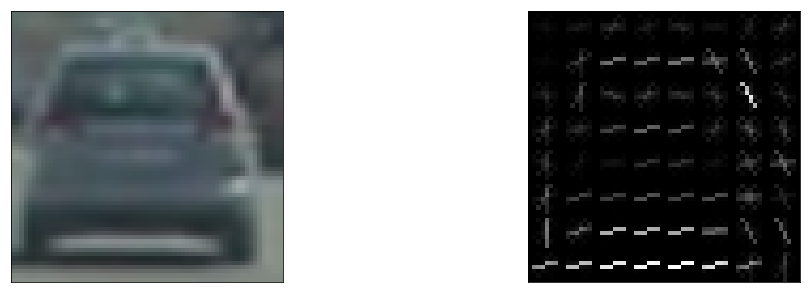

(1764,)


In [4]:
# Helper function to extract HOG features and optional visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec, block_norm='L2-Hys')
        return features

    
## Demo
img = load_image(cars[4])
orient = 9
pix_per_cell = 8
cell_per_block = 2

features, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

print_example_images(img, hog_image)
print(features.shape)

In [5]:
# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features

img = load_image(cars[4])
spatial_size = (16, 16)  # Spatial binning dimensions

features = bin_spatial(img, size=spatial_size)
print(features.shape)

(768,)


In [6]:
# Define a function to compute color histogram features
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

img = load_image(cars[4])
hist_bins = 64  # Number of histogram bins

features = color_hist(img, nbins=hist_bins)
print(features.shape)

(192,)


In [7]:
# Define a function to extract features a single image
# Have this function call bin_spatial() and color_hist()
def extract_features(file, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=-1,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to

    file_features = []
    # Read in each one by one
    image = load_image(file)
    # apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(image)

    # extract spatial features
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        file_features.append(spatial_features)
    # extract histogram features
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        file_features.append(hist_features)
    # extract hog features
    if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == -1:
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        file_features.append(hog_features)
        
    # Return feature vector
    return np.concatenate(file_features)

## Demo
sample = cars[4]
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = -1  # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

features = extract_features(sample, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)

print(features.shape)

(6156,)


In [24]:
# Define a function to extract features from a list of images
def extract_features_from_dataset(files, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(files):
        file_features = extract_features(file, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    
        features.append(file_features)
    # Return list of feature vectors
    return features


color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = -1  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

t = time.time()
car_features = extract_features_from_dataset(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features_from_dataset(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)

t2 = time.time()
print(round(t2 - t, 2), 'Seconds to extract features...')

100%|█████████████████████████████████████| 8968/8968 [01:27<00:00, 102.35it/s]


174.41 Seconds to extract features...


In [8]:
def fit_SVM(car_features, notcar_features, kernel='linear', C=1.0):
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)

    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

    # Use a linear SVC

    svc = SVC(kernel=kernel, C=C)
    # Check the training time for the SVC
    t = time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    
    time_fit = round(t2 - t, 2)
    accuracy = round(svc.score(X_test, y_test), 4)
    
    
    # extract 10 random samples from dataset and run prediction
    len_test = len(X_test)
    t = time.time()
    prediction = svc.predict(X_test)
    t2 = time.time()
    time_prediction = round((t2 - t)/len_test*100, 9)
    
    return svc, X_scaler, accuracy, time_fit, time_prediction


kernel = 'linear'
C = 1.0

if os.path.exists('classifier.pkl'):
    svc = joblib.load('classifier.pkl')
    X_scaler = joblib.load('scaler.pkl')
    print('Previous classifier loaded!')
else:
    svc, X_scaler, accuracy, time_fit, time_prediction = fit_SVM(car_features, notcar_features, kernel=kernel, C=C)
    joblib.dump(svc, 'classifier.pkl')
    joblib.dump(X_scaler, 'scaler.pkl')
    print('Classifier saved to disk!')
        
print('Accuracy:',accuracy)
print('Time to fit:', time_fit,'seconds. Time to predict 100 samples: ',time_prediction,'seconds.')

Previous classifier loaded!


NameError: name 'accuracy' is not defined

# Vehicle Detection Pipeline

In [12]:
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = -1  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

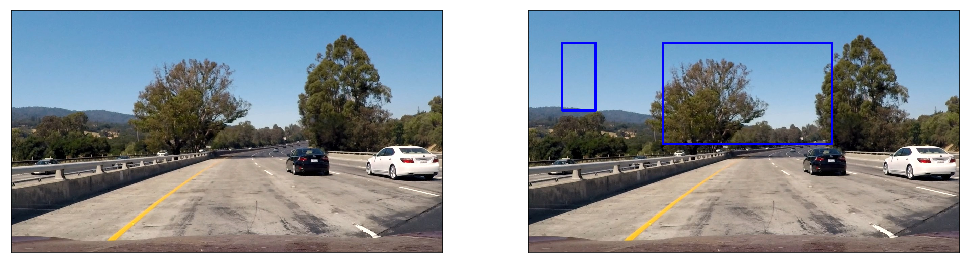

In [15]:
def draw_boxes(img, bboxes, color=(0, 0, 1), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Demo
img = load_image('./test_images/test1.jpg')
bboxes = [((100, 100), (200, 300)), ((400, 100), (900, 400))]
result = draw_boxes(img, bboxes)

print_example_images(img, result)

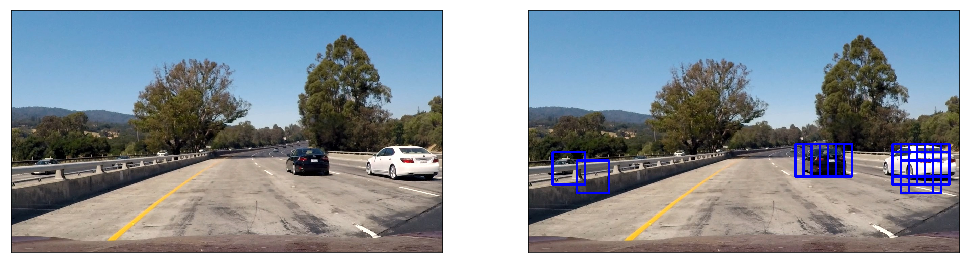

In [16]:
# Define a function you will pass an image and return a list of images to be searched
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bbox_list = []
    draw_img = np.copy(img)
    # scale image
    img = img.astype(np.float32)

    # drop upper part of image
    img_tosearch = img[ystart:ystop, :, :]
    # convert color
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)

    # scale single picture hog to new size
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 1), 6)
                bbox_list.append([(xbox_left, ytop_draw + ystart),(xbox_left + win_draw, ytop_draw + win_draw + ystart)])

    return draw_img, bbox_list

## Demo

ystart = 400
ystop = 656
scale = 1.5

img = load_image('./test_images/test1.jpg')
result, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
print_example_images(img, result)


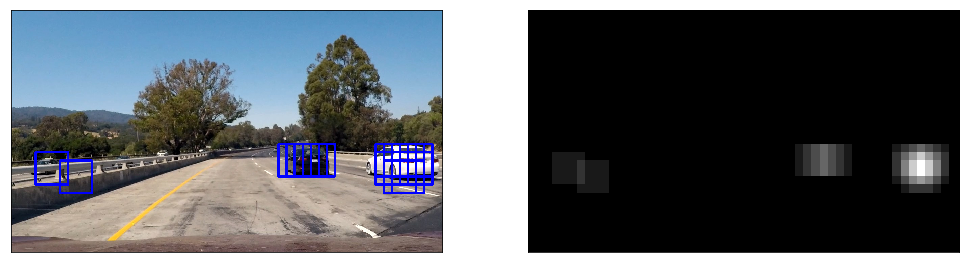

In [17]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

## Demo

heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap,bbox_list)

# clip for displaying
heatmap = np.clip(heatmap, 0, 255)

print_example_images(result, heatmap)

#https://matplotlib.org/users/image_tutorial.html
#In [12]: imgplot = plt.imshow(lum_img)
#In [13]: plt.colorbar()

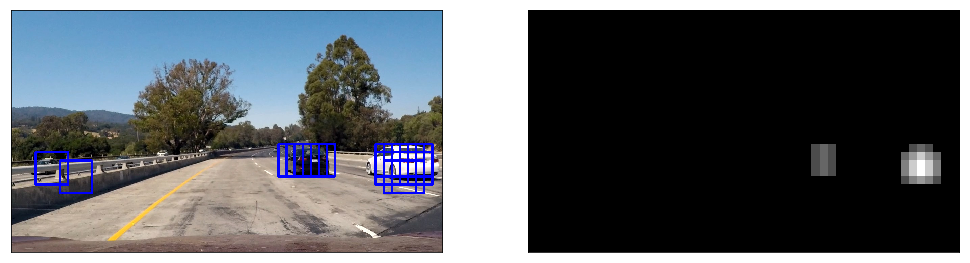

In [18]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heatmap = apply_threshold(heatmap,2)
print_example_images(result, heatmap)

2 cars found


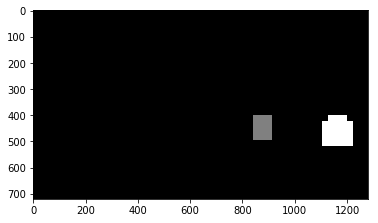

In [19]:
from scipy.ndimage.measurements import label

labels = label(heatmap)


print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

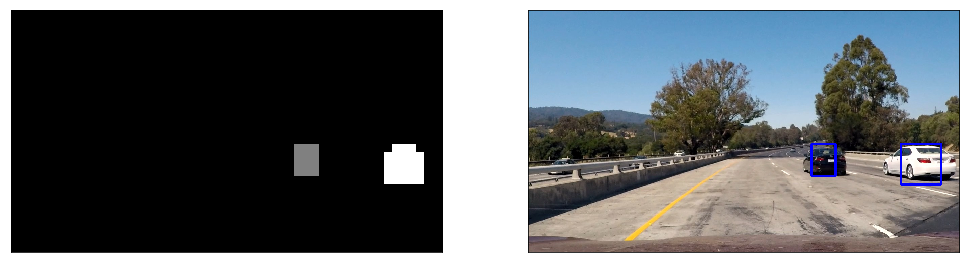

In [20]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,1), 6)
    # Return the image
    return img

# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
print_example_images(labels[0], draw_img)

# Pipeline

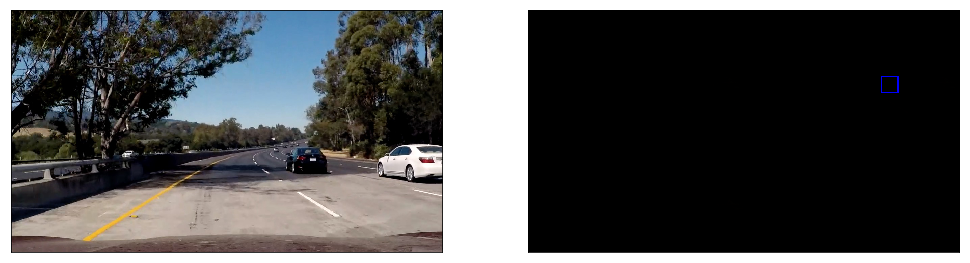

In [31]:
def pipeline_vehicle_detection(img, debug=False):
    
    img = img.astype(np.float32)/255

    bbimg, bbox_list = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heatmap = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap,bbox_list)
    heatmap = apply_threshold(heatmap,2)
    labels = label(heatmap)


    result = draw_labeled_bboxes(np.copy(img), labels)
    
    
    if debug == True: 
        result = np.vstack((img, result)) # put input image and resulting image on top of each other
        bbimg
        heatmap = np.clip(heatmap, 0, 255)
        
        heatmap = np.dstack((heatmap, heatmap, heatmap))
        debug_out = np.vstack((bbimg, heatmap)) # put threshold and debug output on top of each other
        
        result = np.hstack((result, debug_out)) # combine all four images into one

    return result

img = load_image('./test_images/test5.jpg')
result = pipeline_vehicle_detection(img, debug=True)
print_example_images(img, result)

# Video

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output

    return pipeline_vehicle_detection(image, debug=True)

## Test Video

In [34]:
project_output = 'test_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|████████████████████████████████████████▉ | 38/39 [01:30<00:02,  2.40s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 1min 31s


## Project Video

In [ ]:
project_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

# Backup

## Automated test of different extraction parameters and SVC kernels and parameters

In [ ]:
# Automated test of different extraction parameters and SVC kernels and parameters

# load svc that contains all needed parameters in each line
parameter_file = "extraction_parameters_small.csv"
para_pd = pd.read_table(parameter_file, sep=';')
para_pd['spatial_feat'] = para_pd['spatial_feat'].astype('bool')
para_pd['hist_feat'] = para_pd['hist_feat'].astype('bool')
para_pd['hog_feat'] = para_pd['hog_feat'].astype('bool')


# debug output
print(para_pd.shape)

for index, para_row in para_pd.iterrows():
    
    # Skip rows that are alredy calculated
    #if para_row['accuracy'] != 0:
     #   continue
    
    print('Index: ', index)
    kernel = para_row['kernel']
    color_space = para_row['color_space']
    orient = para_row['orient']
    pix_per_cell = para_row['pix_per_cell']
    cell_per_block = para_row['cell_per_block']
    hog_channel = para_row['hog_channel']
    spatial_size = (para_row['spatial_size'], para_row['spatial_size'])
    hist_bins = para_row['hist_bins']
    spatial_feat = para_row['spatial_feat']
    hist_feat = para_row['hist_feat']
    hog_feat = para_row['hog_feat']
    C = para_row['C']
        
    
    t = time.time()
    car_features = extract_features_from_dataset(cars, color_space=color_space,
                                    spatial_size=spatial_size, hist_bins=hist_bins,
                                    orient=orient, pix_per_cell=pix_per_cell,
                                    cell_per_block=cell_per_block,
                                    hog_channel=hog_channel, spatial_feat=spatial_feat,
                                    hist_feat=hist_feat, hog_feat=hog_feat)
    
    notcar_features = extract_features_from_dataset(notcars, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)

    t2 = time.time()
    time_extract = round(t2 - t, 2)
    para_pd.loc[index, 'time_to_extract_features'] = time_extract
    para_pd.loc[index, 'time_to_extract_features_100'] = time_extract*100/(len(car_features)+len(notcar_features))
    para_pd.loc[index, 'features_vector_length'] = int(len(car_features[0]))
    
    svc, X_scaler, accuracy, time_fit, time_prediction = fit_SVM(car_features, notcar_features, kernel=kernel, C=C)
    
    para_pd.loc[index, 'training_time'] = time_fit
    para_pd.loc[index, 'accuracy'] = accuracy   
    
    para_pd.loc[index, 'prediction_time_100'] = time_prediction
    

# save pandas file back to hard drive
para_pd.to_csv(parameter_file, sep=';', index=False)
para_pd

